# Quadrotor SINDy Notebook

## System equations of motion

$$\ddot{y} = \frac{-u_{1}}{m} \sin{\phi}$$
$$\ddot{z} = -g + \frac{-u_{1}}{m} \cos{\phi}$$
$$\ddot{\phi} = \frac{u_{2}}{I_{xx}}$$

In [1]:
import numpy as np
import pandas as pd
import pysindy as ps
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

In [2]:
plt.style.use(['science'])

In [3]:
def load_data(file_dir):
    print('loading data..')
    df = pd.read_csv(file_dir)  #loading pre-data
    print('data loaded')
    return df


def organize_data(df):
    t = df[df.columns[0]]
    y = df[df.columns[1]]
    z = df[df.columns[2]]
    phi = df[df.columns[3]]
    v = df[df.columns[4]]
    w = df[df.columns[5]]
    phi_dot = df[df.columns[6]]
    u1 = df[df.columns[7]]
    u2 = df[df.columns[8]]
    y_ref = df[df.columns[9]]
    z_ref = df[df.columns[10]]
    return t, y, z, phi, v, w, phi_dot, u1, u2, y_ref, z_ref


def viz_data(df):
    t, y, z, phi, v, w, phi_dot, u1, u2, y_ref, z_ref = organize_data(df)

    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(19, 6))
    axs[0, 0].plot(t, y, color='teal', label='Sys. response in $y$', lw=4, alpha=0.5)
    axs[0, 0].plot(t,
                   y_ref,
                   color='red',
                   ls='--',
                   lw=2,
                   label='Ref. trajectory in $y$')
    axs[0, 0].set_ylabel(r'$y$')
    axs[0, 0].legend()

    axs[1, 0].plot(t, z, color='teal', lw=4, alpha=0.5)
    axs[1, 0].plot(t, z_ref, color='red', ls='--', lw=2)
    axs[1, 0].legend()
    axs[1, 0].set_ylabel(r'$z$')

    axs[2, 0].plot(t, phi, color='teal', lw=4, alpha=0.5)
    axs[2, 0].set_ylabel(r'$\phi$')
    axs[2, 0].set_xlabel(r'$t$')

    axs[0, 1].plot(t, u1, color='teal', lw=4, alpha=0.5)
    axs[0, 1].set_ylabel(r'$u_1$')

    axs[1, 1].plot(t, u2, color='teal', lw=4, alpha=0.5)
    axs[1, 1].set_ylabel(r'$u_2$')
    axs[1, 1].set_xlabel(r'$t$')

    axs[2, 1].sharex = False
    axs[2, 1].plot(y, z, color='teal', label='Sys. response', lw=4, alpha=0.5)
    axs[2, 1].plot(y_ref,
                   z_ref,
                   color='red',
                   ls='--',
                   lw=2,
                   label='Ref. trajectory in')
    axs[2, 1].set_xlabel(r'$y$')
    axs[2, 1].set_ylabel(r'$z$')
    axs[2, 1].set_aspect('auto')

    plt.show()


def get_states_and_controls(df):
    t, y, z, phi, v, w, phi_dot, u1, u2, y_ref, z_ref = organize_data(df)
    X = np.stack((y, z, phi, v, w, phi_dot), axis=-1)
    U = np.stack((u1, u2), axis=-1)
    return t, X, U

In [4]:
# load data
file_dir = '../DATA/all_out.csv'
df = load_data(file_dir)

loading data..
data loaded


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


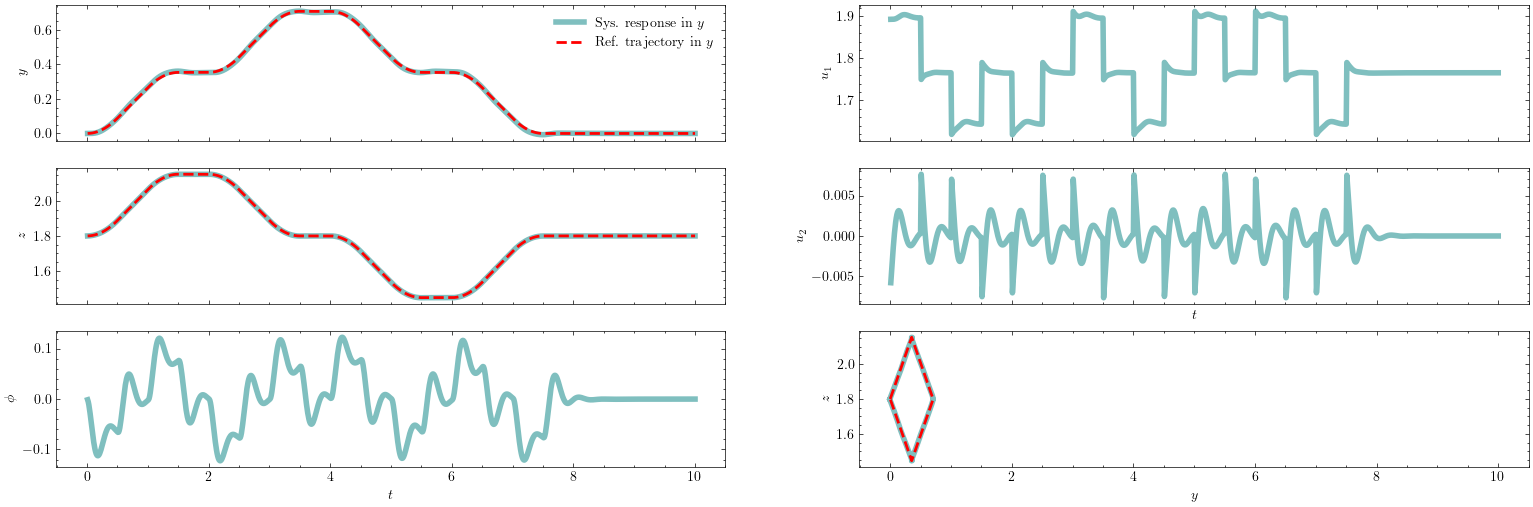

In [5]:
viz_data(df)

In [6]:
t, X, U = get_states_and_controls(df)

In [7]:
t = t.to_numpy()
dt = t[1] - t[0]
print('time step = {}'.format(dt))

time step = 0.01


In [8]:
X.shape

(1000, 6)

In [9]:
U.shape

(1000, 2)

In [10]:
differentiation_method = ps.FiniteDifference(order=1)

In [11]:
poly_library = ps.PolynomialLibrary(degree=1)
fourier_library = ps.FourierLibrary()

n_inputs = 8
n_libs = 2

# Initialize the default inputs, i.e. each library
# uses all the input variables, (8 inputs and 2 libraries here)
inputs_temp = np.tile(np.arange(0, n_inputs, 1), n_libs)
inputs_per_library = np.reshape(inputs_temp, (n_libs, n_inputs))
print(inputs_per_library)

[[0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]]


In [12]:
# Don't use the phi inputs for generating the polynomila library
inputs_per_library[0, 2] = 1

# only use phi in the Fourier library
inputs_per_library[1, 0] = 2
inputs_per_library[1, 1] = 2
inputs_per_library[1, 2] = 2
inputs_per_library[1, 3] = 2
inputs_per_library[1, 4] = 2
inputs_per_library[1, 5] = 2
inputs_per_library[1, 6] = 2
inputs_per_library[1, 7] = 2

print(inputs_per_library)

[[0 1 1 3 4 5 6 7]
 [2 2 2 2 2 2 2 2]]


In [13]:
# Tensor all the polynomial and Fourier library terms together
# and tensor all the Fourier and Custom library terms together.
tensor_array = [[1, 1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

print(generalized_library)

In [14]:
optimizer = ps.SR3(threshold=0.45, thresholder="l1", max_iter=1000, tol=1e-1)
feature_names = ["y", "z", "phi", "y'", "z'", "phi'", "u1", "u2"]

model = ps.SINDy(differentiation_method=differentiation_method,
                 feature_library=generalized_library,
                 optimizer=optimizer,
                 feature_names=feature_names)

model.fit(X, u=U, t=dt, ensemble=True)

SINDy(differentiation_method=FiniteDifference(order=1),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x1579b5c90>,
      feature_names=['y', 'z', 'phi', "y'", "z'", "phi'", 'u1', 'u2'],
      optimizer=SR3(max_iter=1000, threshold=0.45, thresholder='l1', tol=0.1))

In [15]:
model.get_feature_names()

['1',
 'y',
 'z',
 "y'",
 "z'",
 "phi'",
 'u1',
 'u2',
 'sin(1 phi)',
 'cos(1 phi)',
 '1 sin(1 phi)',
 '1 cos(1 phi)',
 'y sin(1 phi)',
 'y cos(1 phi)',
 'z sin(1 phi)',
 'z cos(1 phi)',
 "y' sin(1 phi)",
 "y' cos(1 phi)",
 "z' sin(1 phi)",
 "z' cos(1 phi)",
 "phi' sin(1 phi)",
 "phi' cos(1 phi)",
 'u1 sin(1 phi)',
 'u1 cos(1 phi)',
 'u2 sin(1 phi)',
 'u2 cos(1 phi)']

In [16]:
model.print()

(y)' = 1.000 y'
(z)' = 1.000 z'
(phi)' = 0.993 phi' cos(1 phi)
(y')' = -5.549 u1 sin(1 phi)
(z')' = -9.811 1 + 5.556 u1 cos(1 phi)
(phi')' = 4000.000 u2


In [17]:
x_dot_test_predicted = model.predict(X, u=U)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(X, t=dt)

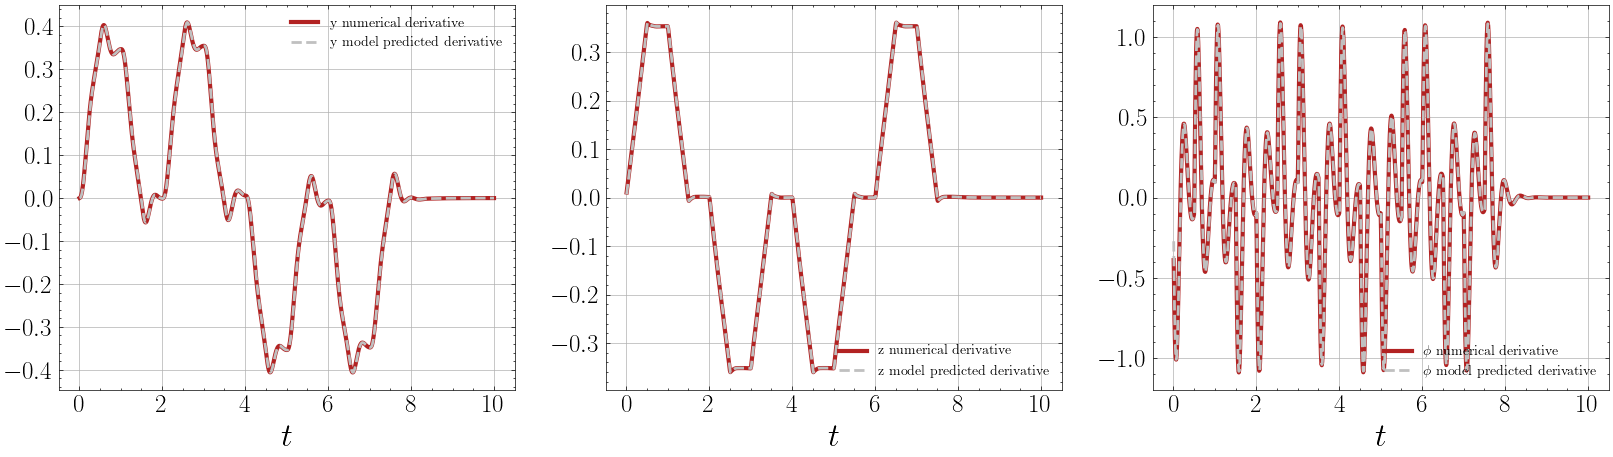

In [18]:
feature_name = ["y", "z", r"$\phi$"]
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t,
             x_dot_test_computed[:, i],
             color='firebrick',
             linewidth=3,
             label=feature_name[i] + ' numerical derivative')
    plt.plot(t,
             x_dot_test_predicted[:, i],
             color='silver',
             lw=2,
             linestyle='--',
             label=feature_name[i] + ' model predicted derivative')
    plt.grid(True)
    plt.xlabel(r"$t$", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=12)

    plt.legend()